### LASSO parameter range experiments

We want to see whether smaller models (i.e. models with fewer nonzero features) tend to generalize to new cancer types better than larger ones; this script compares/visualizes those results.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
ll_results_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_ll', 'gene'
)

sgd_results_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_sgd', 'gene'
)

plot_gene = 'EGFR'
metric = 'aupr'

### Get coefficient information for each lasso penalty

### Get performance information for each lasso penalty

In [3]:
ll_perf_df = au.load_prediction_results_lasso_range(ll_results_dir,
                                                    'stratified',
                                                    gene=plot_gene)
ll_perf_df = (
    ll_perf_df[ll_perf_df.gene == plot_gene]
    .drop(columns=['holdout_cancer_type', 'experiment'])
    .copy()
)
ll_perf_df.head()

,auroc,aupr,gene,signal,seed,data_type,fold,lasso_param
0,1.00000,1.00000,EGFR,signal,42,train,0,50.0
1,0.82416,0.55618,EGFR,signal,42,test,0,50.0
2,0.79098,0.46818,EGFR,signal,42,cv,0,50.0
3,1.00000,1.00000,EGFR,signal,42,train,1,50.0
4,0.82871,0.54983,EGFR,signal,42,test,1,50.0


In [4]:
sgd_perf_df = au.load_prediction_results_lasso_range(sgd_results_dir,
                                                     'stratified',
                                                     gene=plot_gene)
sgd_perf_df = (
    sgd_perf_df[sgd_perf_df.gene == plot_gene]
    .drop(columns=['holdout_cancer_type', 'experiment'])
    .copy()
)
sgd_perf_df.head()

,auroc,aupr,gene,signal,seed,data_type,fold,lasso_param
0,0.85248,0.53980,EGFR,signal,42,train,0,0.05
1,0.70647,0.39853,EGFR,signal,42,test,0,0.05
2,0.74999,0.41489,EGFR,signal,42,cv,0,0.05
3,0.83502,0.40732,EGFR,signal,42,train,1,0.05
4,0.80111,0.33415,EGFR,signal,42,test,1,0.05


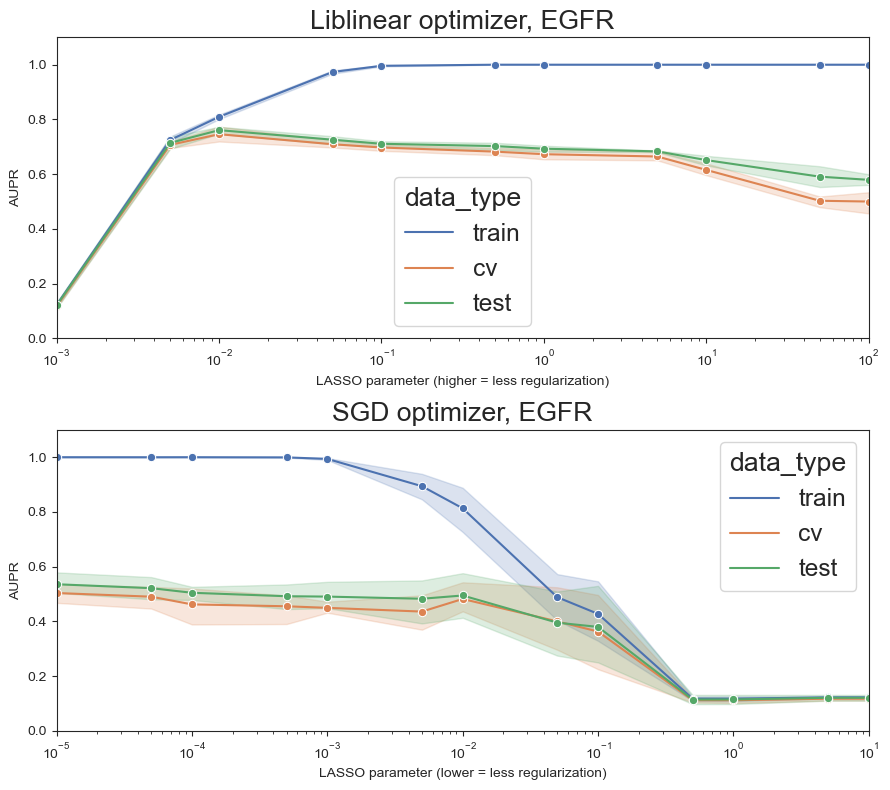

In [5]:
# plot LASSO parameter vs. AUPR, for all 3 datasets
# "train" = data used to train model
# "cv" = validation set from TCGA (not used to train model)
# "test" = CCLE data (not used to train model)
sns.set({'figure.figsize': (9, 8)})
sns.set_style('ticks')

fig, axarr = plt.subplots(2, 1)

ll_plot_df = (
    ll_perf_df[(ll_perf_df.signal == 'signal')]
      .sort_values(by=['lasso_param'])
      .reset_index(drop=True)
)
ll_plot_df.lasso_param = ll_plot_df.lasso_param.astype(float)

sgd_plot_df = (
    sgd_perf_df[(sgd_perf_df.signal == 'signal')]
      .sort_values(by=['lasso_param'])
      .reset_index(drop=True)
)
sgd_plot_df.lasso_param = sgd_plot_df.lasso_param.astype(float)

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.lineplot(
        data=ll_plot_df,
        x='lasso_param', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o',
        ax=axarr[0]
    )
    g.set(xscale='log',
          xlim=(min(ll_plot_df.lasso_param), max(ll_plot_df.lasso_param)),
          ylim=(0.0, 1.1))
    g.set_title(f'Liblinear optimizer, {plot_gene}')
    g.set_xlabel('LASSO parameter (higher = less regularization)')
    g.set_ylabel(f'{metric.upper()}')
    
    g = sns.lineplot(
        data=sgd_plot_df,
        x='lasso_param', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o',
        ax=axarr[1]
    )
    g.set(xscale='log',
          xlim=(min(sgd_plot_df.lasso_param), max(sgd_plot_df.lasso_param)),
          ylim=(0.0, 1.1))
    g.set_title(f'SGD optimizer, {plot_gene}')
    g.set_xlabel('LASSO parameter (lower = less regularization)')
    g.set_ylabel(f'{metric.upper()}')
    
plt.tight_layout()

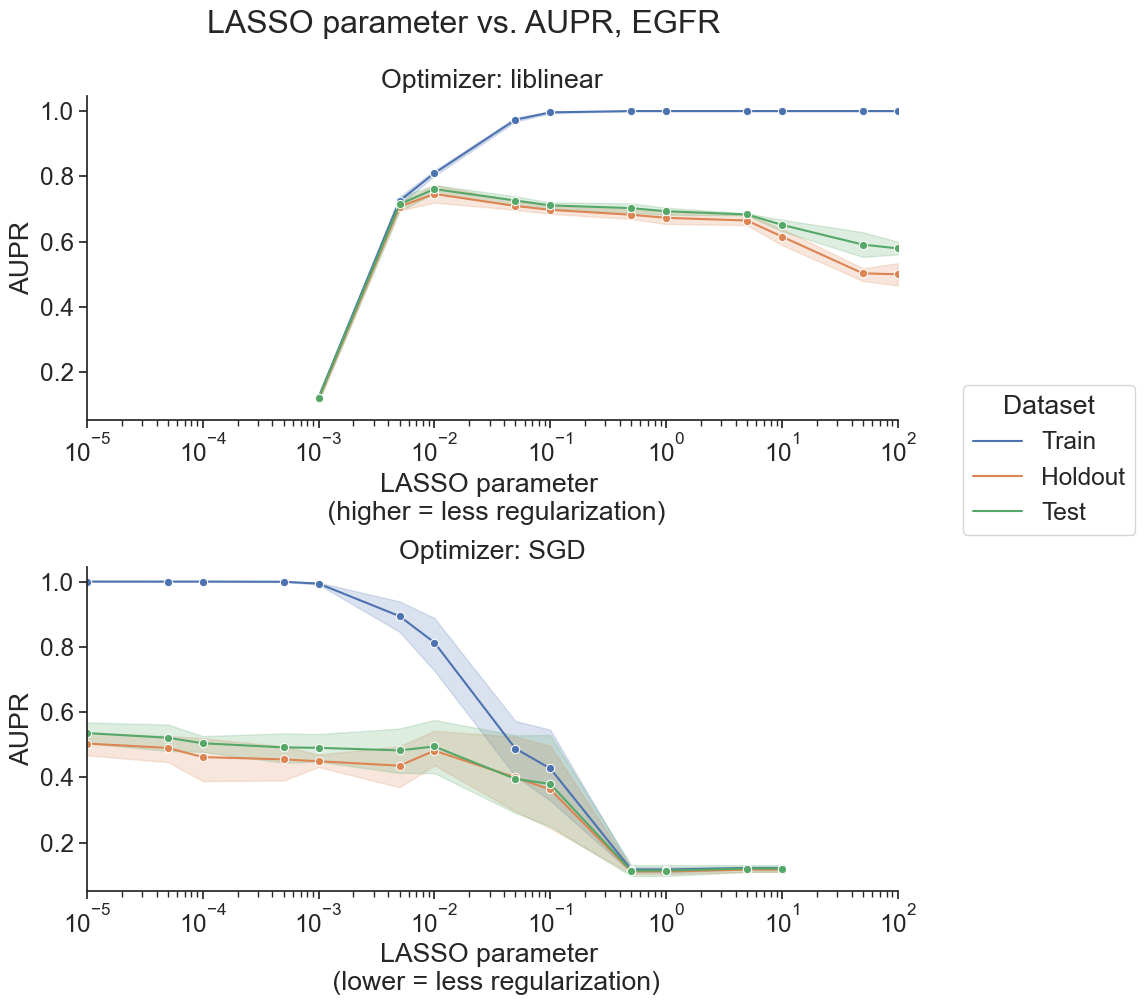

In [6]:
# same plot as before but with the "best"/"smallest" parameters marked
sns.set_style('ticks')

ll_plot_df['optimizer'] = 'liblinear'
sgd_plot_df['optimizer'] = 'SGD'

plot_df = pd.concat((ll_plot_df, sgd_plot_df))

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=plot_df,
        x='lasso_param', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o', kind='line', col='optimizer',
        col_wrap=1, height=5, aspect=1.6,
        facet_kws={'sharex': False}
    )
    g.set(xscale='log', xlim=(min(plot_df.lasso_param), max(plot_df.lasso_param)))
    g.axes[0].set_xlabel('LASSO parameter \n (higher = less regularization)')
    g.axes[1].set_xlabel('LASSO parameter \n (lower = less regularization)')
    g.set_ylabels(f'{metric.upper()}')
    sns.move_legend(g, "center", bbox_to_anchor=[1.125, 0.55], frameon=True)
    g._legend.set_title('Dataset')
    new_labels = ['Train', 'Holdout', 'Test']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    g.set_titles('Optimizer: {col_name}')
     
    plt.suptitle(f'LASSO parameter vs. {metric.upper()}, {plot_gene}', y=1.0)

plt.tight_layout()